# HVM Startup Shear: NLSQ + NUTS Bayesian Inference

## Introduction

This notebook demonstrates the **full Bayesian inference pipeline** for fitting the
HVM to startup shear data with stress overshoot. The workflow follows the RheoJAX
standard: NLSQ point estimation for warm-start, then NumPyro NUTS sampling for
uncertainty quantification.

**Physical context:** Startup shear at constant rate $\dot{\gamma}$ is the key
protocol for probing **mechanochemical coupling** in vitrimers. During startup:
- **P-network**: Linear growth $\sigma_P = G_P \dot{\gamma} t$ (permanent crosslinks)
- **E-network**: Stress overshoot because $\mu^E_{nat}$ lags $\mu^E$ — the TST term
  $\cosh(V_{act}\sigma_{VM}^E/RT)$ accelerates BER, creating a transient peak before
  $\sigma_E \to 0$ at steady state
- **D-network**: Conventional Maxwell overshoot with steady-state viscosity $\eta_D = G_D/k_d^D$

The overshoot magnitude and position are directly controlled by $V_{act}$
(activation volume), making startup shear the **primary protocol for determining this
parameter**. Materials with strong mechanochemical coupling (large $V_{act}$) show
prominent overshoots; those with weak coupling show monotonic approach to steady state.

> **Handbook:** See [HVM Knowledge Extraction](../../docs/source/models/hvm/hvm_knowledge.rst)
> for the role of startup in the multi-protocol fitting strategy (step 4: $V_{act}$
> determination). See [HVM Protocol Derivations](../../docs/source/models/hvm/hvm_protocols.rst)
> for the startup ODE and analytical constant-rate solution.

## Workflow

1. Load startup shear data $\sigma(t)$ at known $\dot{\gamma}$
2. NLSQ optimization for point estimates
3. Bayesian inference with NUTS for uncertainty quantification
4. Stress component decomposition and natural-state lag visualization
5. Shear rate comparison (overshoot dependence)

## Prerequisites

- **Notebook 01** (SAOS) — HVM architecture, parameter meanings, TST kinetics
- **Notebook 03** (Startup basics) — Stress overshoot mechanism, rate dependence

## Estimated Runtime

- ~5 min (NLSQ + NUTS + multi-rate comparison in FAST_MODE)

## 1. Setup

In [1]:
# Core imports with float64 configuration
from rheojax.core.jax_config import safe_import_jax, verify_float64

jax, jnp = safe_import_jax()
verify_float64()

import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# Add utils to path
sys.path.insert(0, str(Path("..").resolve()))

from utils.hvm_data import check_data_quality, load_pnas_startup
from utils.hvm_fit import (
    FAST_MODE,
    get_bayesian_config,
    get_output_dir,
    plot_trace_and_forest,
    print_convergence,
    print_parameter_table,
    run_nlsq_protocol,
    run_nuts,
    save_figure,
    save_results,
)

from rheojax.models import HVMLocal

%matplotlib inline

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"Fast mode: {FAST_MODE}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX version: 0.8.3
JAX devices: [CpuDevice(id=0)]
Fast mode: True


## 2. Load Data

PNAS Digital Rheometer Twin startup shear data at $\dot{\gamma} = 1.0$ s$^{-1}$.

**Important:** This data is from a thixotropic fluid, not a true vitrimer. We use it as a proxy because:
- Stress overshoot behavior is qualitatively similar
- Demonstrates HVM capability to fit transient shear flows
- Real vitrimer startup data would show similar features but with different physical origins

In [2]:
# Load startup data at γ̇ = 1.0 s⁻¹
gamma_dot = 1.0
time, stress = load_pnas_startup(gamma_dot=gamma_dot, max_points=200)

# Quality checks
check_data_quality(time, stress, f"PNAS Startup γ̇={gamma_dot}")

print(f"Data points: {len(time)}")
print(f"Time range: {time.min():.2e} - {time.max():.2e} s")
print(f"Stress range: {stress.min():.2e} - {stress.max():.2e} Pa")
print(f"Shear rate: {gamma_dot} s⁻¹")

# Find peak (overshoot)
peak_idx = np.argmax(stress)
stress_peak = stress[peak_idx]
time_peak = time[peak_idx]
strain_peak = gamma_dot * time_peak

print(f"\nOvershoot:")
print(f"  Peak stress: {stress_peak:.2f} Pa")
print(f"  Peak time: {time_peak:.2f} s")
print(f"  Peak strain: {strain_peak:.2f}")

Data QC: PNAS Startup γ̇=1.0
  Points: 200
  x range: [0.005331, 600]
  y range: [0.6885, 26.11]
  Status: PASSED
Data points: 200
Time range: 5.33e-03 - 6.00e+02 s
Stress range: 6.88e-01 - 2.61e+01 Pa
Shear rate: 1.0 s⁻¹

Overshoot:
  Peak stress: 26.11 Pa
  Peak time: 3.02 s
  Peak strain: 3.02


## 3. Data Exploration

Linear plot reveals stress overshoot — hallmark of transient behavior.

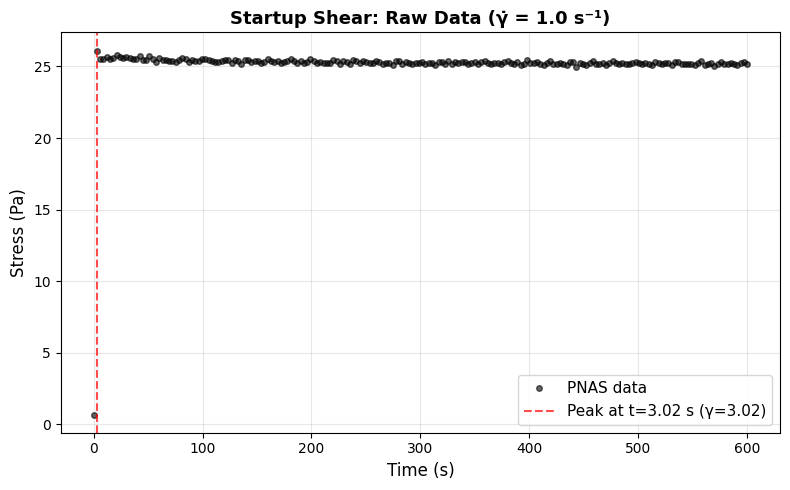

In [3]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(time, stress, 'ko', markersize=4, alpha=0.6, label='PNAS data')
ax.axvline(time_peak, color='red', ls='--', lw=1.5, alpha=0.7,
           label=f'Peak at t={time_peak:.2f} s (γ={strain_peak:.2f})')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Stress (Pa)', fontsize=12)
ax.set_title(f'Startup Shear: Raw Data (γ̇ = {gamma_dot} s⁻¹)', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Model Setup

HVM with all 3 subnetworks for startup shear:
- **P-network**: Linear growth $\sigma_P = G_P \dot{\gamma} t$
- **E-network**: Overshoot from $\mu^E_{nat}$ lag, then $\sigma_E \to 0$ at steady state
- **D-network**: Conventional Maxwell overshoot, steady-state viscosity

In [4]:
# Initialize model with dissociative network
model = HVMLocal(include_dissociative=True)

# Set temperature
model.parameters.set_value("T", 300.0)

# Initial parameter guesses (adjusted for this material)
model.parameters.set_value("G_P", 30.0)  # Permanent modulus
model.parameters.set_value("G_E", 20.0)  # Exchangeable modulus
model.parameters.set_value("G_D", 15.0)  # Dissociative modulus
model.parameters.set_value("nu_0", 1e10)  # BER attempt frequency
model.parameters.set_value("E_a", 80e3)  # Activation energy (J/mol)
model.parameters.set_value("V_act", 1e-5)  # Activation volume (m³)
model.parameters.set_value("k_d_D", 1.0)  # Dissociative rate (1/s)

# Display initial parameters
print("Initial parameters:")
for name in ["G_P", "G_E", "G_D", "nu_0", "E_a", "V_act", "k_d_D"]:
    param = model.parameters[name]
    print(f"  {name}: {param.value:.2e} {param.units} (bounds: {param.bounds})")

Initial parameters:
  G_P: 3.00e+01 Pa (bounds: (0.0, 1000000000.0))
  G_E: 2.00e+01 Pa (bounds: (0.0, 1000000000.0))
  G_D: 1.50e+01 Pa (bounds: (0.0, 100000000.0))
  nu_0: 1.00e+10 1/s (bounds: (1000000.0, 100000000000000.0))
  E_a: 8.00e+04 J/mol (bounds: (20000.0, 200000.0))
  V_act: 1.00e-05 m^3/mol (bounds: (1e-08, 0.01))
  k_d_D: 1.00e+00 1/s (bounds: (1e-06, 1000000.0))


## 5. NLSQ Fit

Fast point estimation with protocol-specific kwargs (gamma_dot).

In [5]:
# Run NLSQ optimization
nlsq_result = run_nlsq_protocol(
    model,
    time,
    stress,
    test_mode='startup',
    gamma_dot=gamma_dot,
)

print("\nNLSQ fitted parameters:")
for name in ["G_P", "G_E", "G_D", "nu_0", "E_a", "V_act", "k_d_D"]:
    value = model.parameters.get_value(name)
    unit = model.parameters[name].units
    print(f"  {name}: {value:.2e} {unit}")

# Compute characteristic times
k_BER_0 = model.parameters.get_value("nu_0") * np.exp(
    -model.parameters.get_value("E_a") / (8.314 * model.parameters.get_value("T"))
)
tau_E = 1.0 / (2.0 * k_BER_0)
tau_D = 1.0 / model.parameters.get_value("k_d_D")

print(f"\nCharacteristic times:")
print(f"  τ_E = {tau_E:.2e} s")
print(f"  τ_D = {tau_D:.2e} s")
print(f"  Strain to peak: γ_peak = {strain_peak:.2f}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.538304s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=9 | final_cost=130.2662 | elapsed=1.538s | final_gradient_norm=386.9879



NLSQ fitted parameters:
  G_P: 1.37e-01 Pa
  G_E: 1.96e-01 Pa
  G_D: 1.75e-01 Pa
  nu_0: 2.68e+12 1/s
  E_a: 2.06e+04 J/mol
  V_act: 1.55e-03 m^3/mol
  k_d_D: 9.87e+05 1/s

Characteristic times:
  τ_E = 2.67e-11 s
  τ_D = 1.01e-06 s
  Strain to peak: γ_peak = 3.02


## 6. Plot Fit

Overlay NLSQ fit with overshoot annotation.

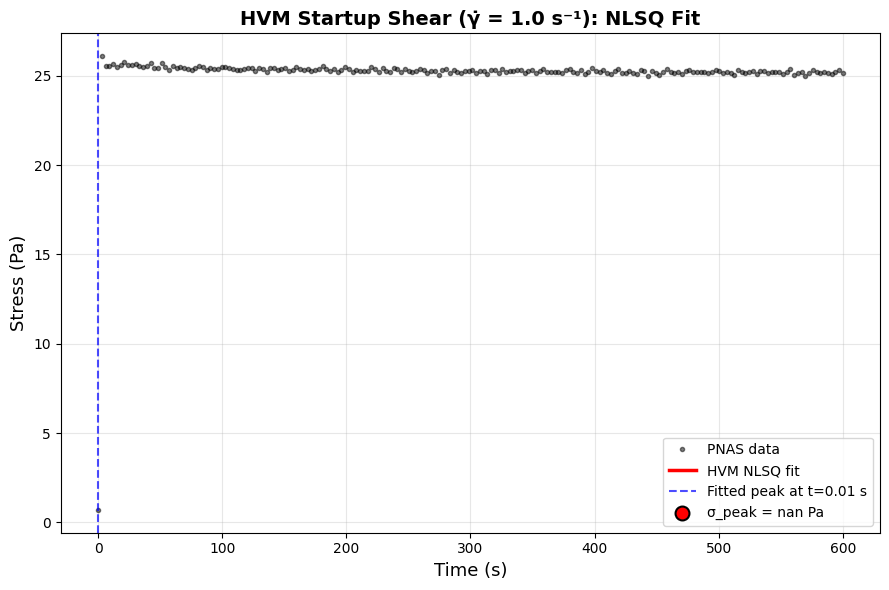


NLSQ R² = nan


In [6]:
# Generate smooth prediction
t_fit = np.linspace(time.min(), time.max(), 300)
stress_fit = model.simulate_startup(t_fit, gamma_dot=gamma_dot)

# Find fitted peak
peak_idx_fit = np.argmax(stress_fit)
stress_peak_fit = stress_fit[peak_idx_fit]
time_peak_fit = t_fit[peak_idx_fit]

# Plot
fig, ax = plt.subplots(figsize=(9, 6))

# Data and fit
ax.plot(time, stress, 'ko', markersize=3, alpha=0.5, label='PNAS data')
ax.plot(t_fit, stress_fit, 'r-', lw=2.5, label='HVM NLSQ fit')

# Annotations
ax.axvline(time_peak_fit, color='blue', ls='--', lw=1.5, alpha=0.7,
           label=f'Fitted peak at t={time_peak_fit:.2f} s')
ax.scatter([time_peak_fit], [stress_peak_fit], s=100, c='red',
           edgecolors='black', linewidths=1.5, zorder=5,
           label=f'σ_peak = {stress_peak_fit:.2f} Pa')

ax.set_xlabel('Time (s)', fontsize=13)
ax.set_ylabel('Stress (Pa)', fontsize=13)
ax.set_title(f'HVM Startup Shear (γ̇ = {gamma_dot} s⁻¹): NLSQ Fit', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

# Compute R²
stress_pred = model.simulate_startup(time, gamma_dot=gamma_dot)
ss_res = np.sum((stress - stress_pred)**2)
ss_tot = np.sum((stress - np.mean(stress))**2)
r_squared = 1.0 - ss_res / ss_tot
print(f"\nNLSQ R² = {r_squared:.6f}")

## 7. Bayesian Inference

NumPyro NUTS with NLSQ warm-start.

In [7]:
# Get Bayesian configuration
bayes_config = get_bayesian_config()

print("Bayesian inference configuration:")
for key, val in bayes_config.items():
    print(f"  {key}: {val}")

# Run NUTS
nuts_result = run_nuts(
    model,
    time,
    stress,
    test_mode='startup',
    **bayes_config,
)

# Define parameter names for diagnostics
param_names = list(model.parameters.keys())

# Print diagnostics
print("\n" + "="*60)
print("CONVERGENCE DIAGNOSTICS")
print("="*60)
print_convergence(nuts_result, param_names)

print("\n" + "="*60)
print("PARAMETER POSTERIOR SUMMARY")
print("="*60)
print_parameter_table(param_names, nlsq_result, nuts_result.posterior_samples)

Bayesian inference configuration:
  num_warmup: 50
  num_samples: 100
  num_chains: 1


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:01<02:31,  1.02s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

sample:  41%|████      | 61/150 [00:01<00:01, 74.55it/s, 255 steps of size 1.68e-04. acc. prob=0.97]

sample:  64%|██████▍   | 96/150 [00:01<00:00, 110.07it/s, 255 steps of size 1.68e-04. acc. prob=0.94]

sample:  85%|████████▍ | 127/150 [00:01<00:00, 138.10it/s, 255 steps of size 1.68e-04. acc. prob=0.92]

sample: 100%|██████████| 150/150 [00:01<00:00, 102.13it/s, 255 steps of size 1.68e-04. acc. prob=0.91]


CONVERGENCE DIAGNOSTICS
Convergence Diagnostics
   Parameter     R-hat       ESS
--------------------------------------------------
         G_P    3.0119         3 *
         G_E    1.3527         6 *
        nu_0    2.6189         3 *
         E_a    1.5950         4 *
       V_act    1.3145         5 *
           T    1.1079        10 *
         G_D    1.7728         4 *
       k_d_D    3.2431         3 *

Divergences: 0
Convergence: CHECK REQUIRED

PARAMETER POSTERIOR SUMMARY

Parameter Comparison
       Param          NLSQ   Bayes (med)                    95% CI
------------------------------------------------------------------
         G_P        0.1374      0.007332  [0.005591, 0.009483]
         G_E         0.196         590.6  [303.6, 2808]
        nu_0      2.68e+12     8.025e+13  [7.09e+13, 8.49e+13]
         E_a     2.056e+04     9.903e+04  [9.495e+04, 1.056e+05]
       V_act      0.001545      0.004738  [0.004356, 0.005215]
           T         498.1         406.4  [397, 

## 8. MCMC Diagnostics

Visual inspection of chain mixing and parameter distributions.

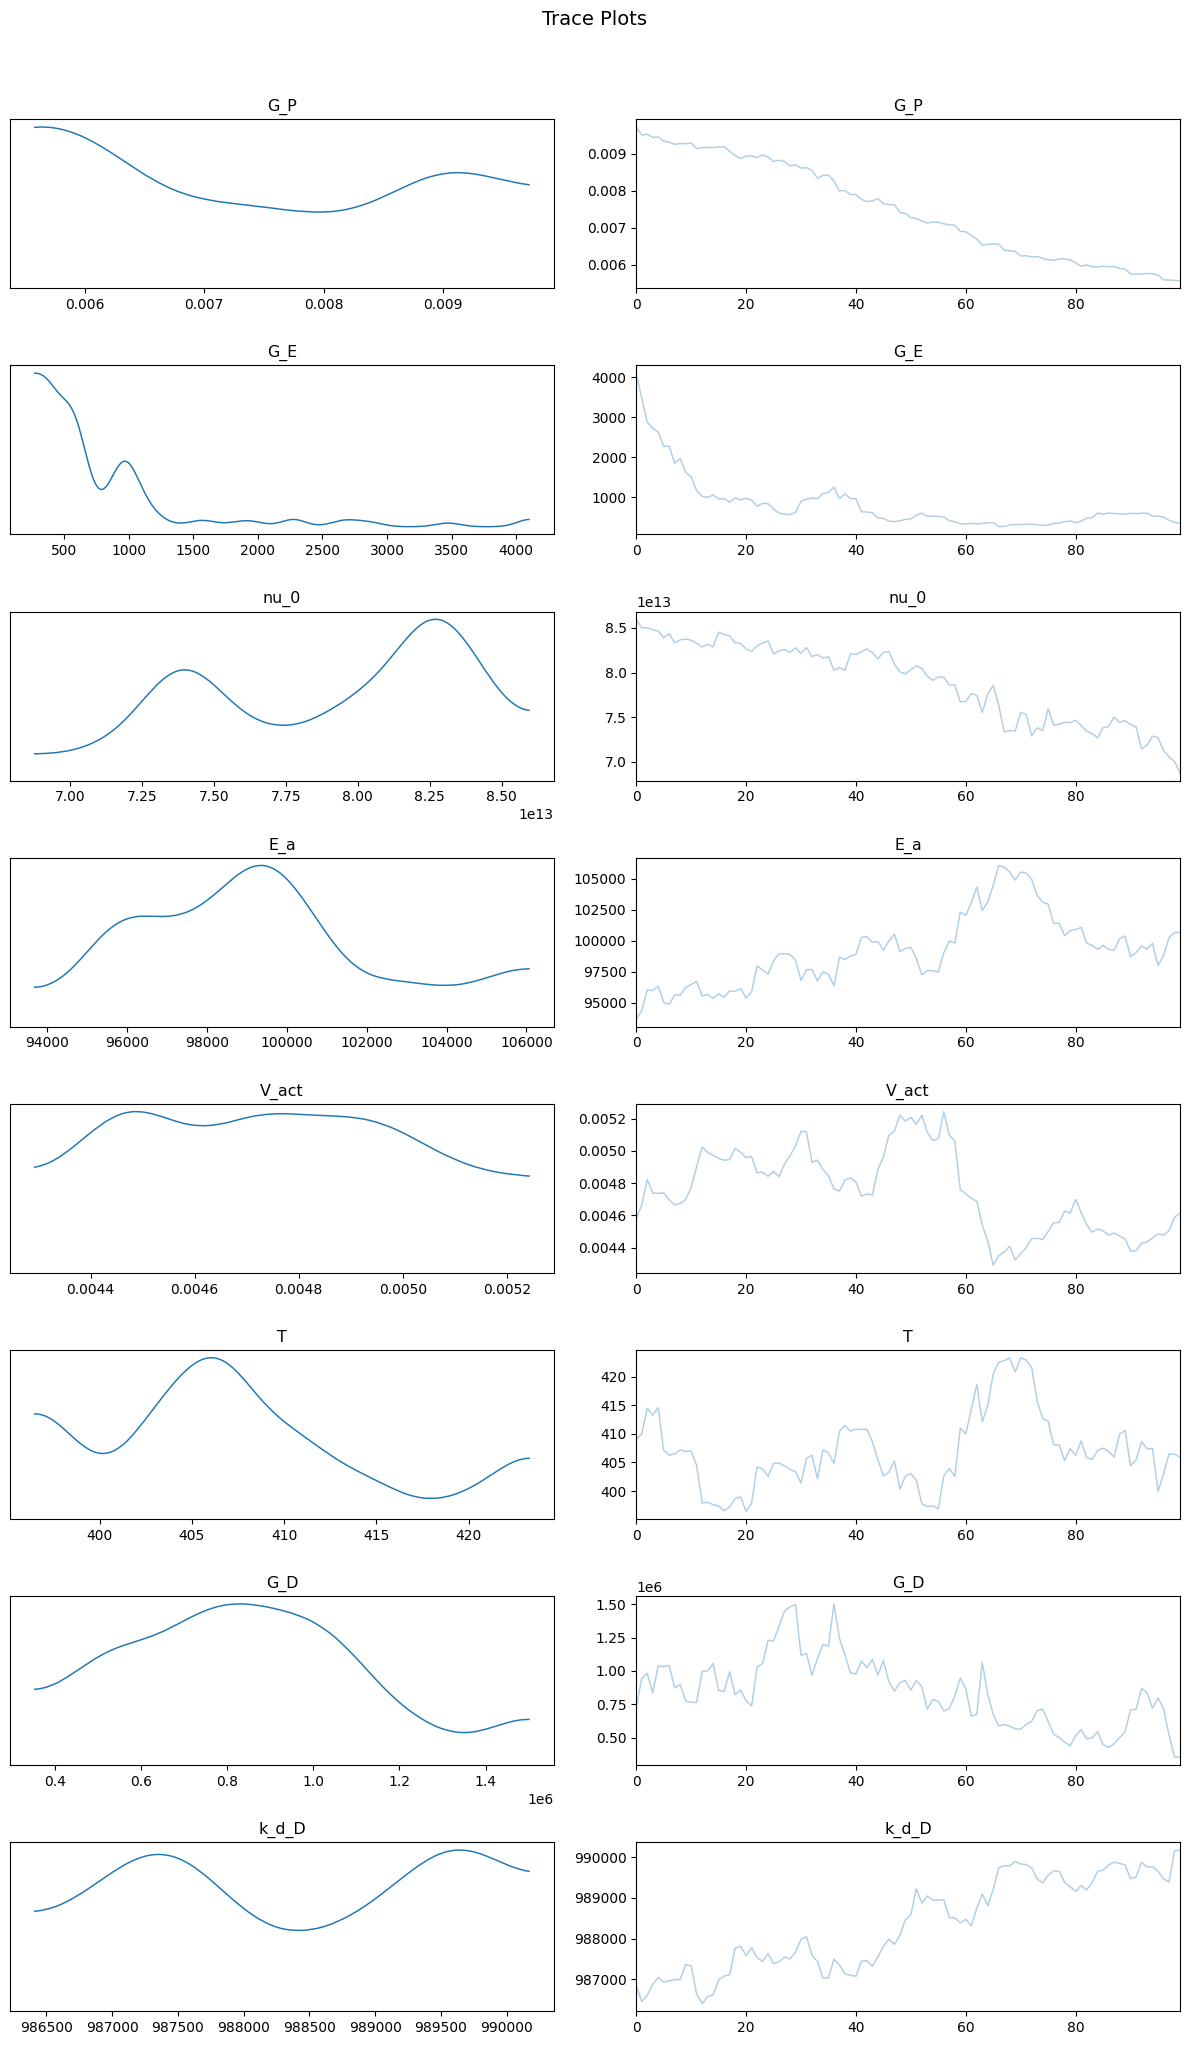

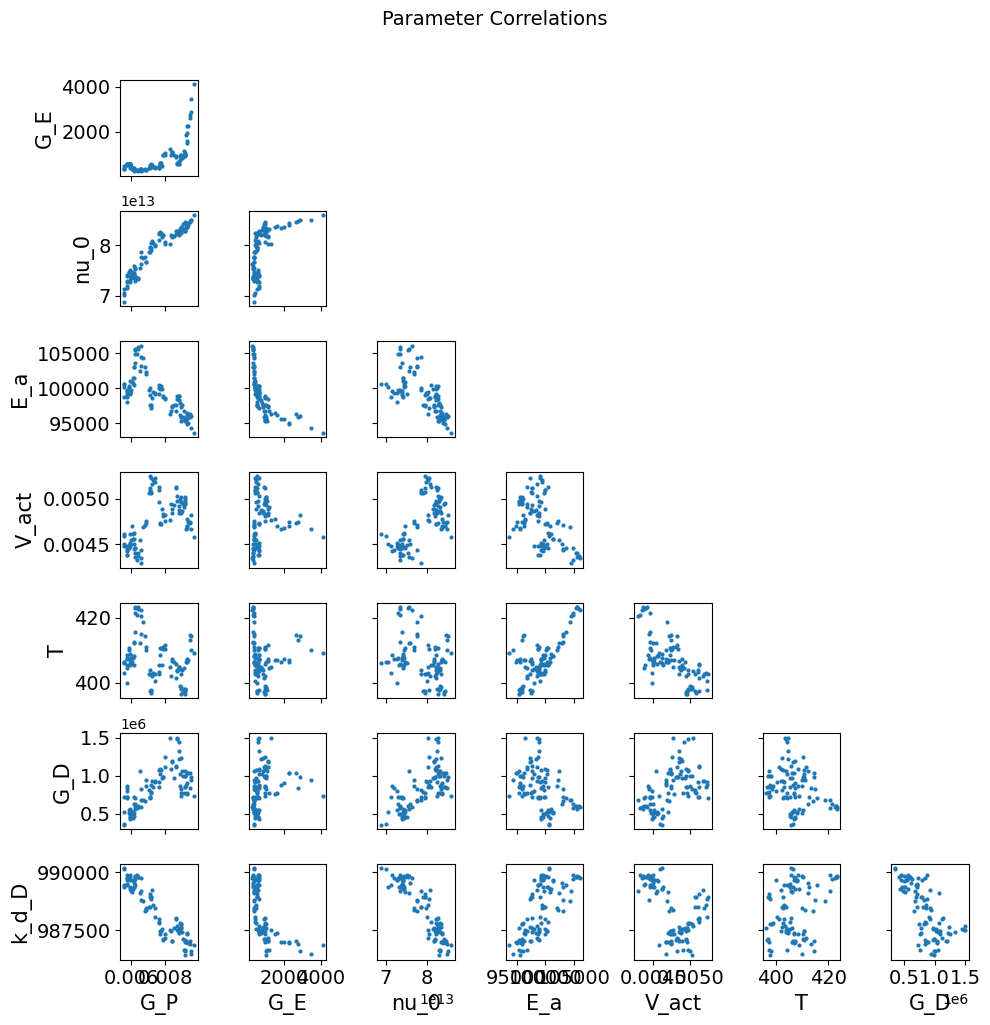

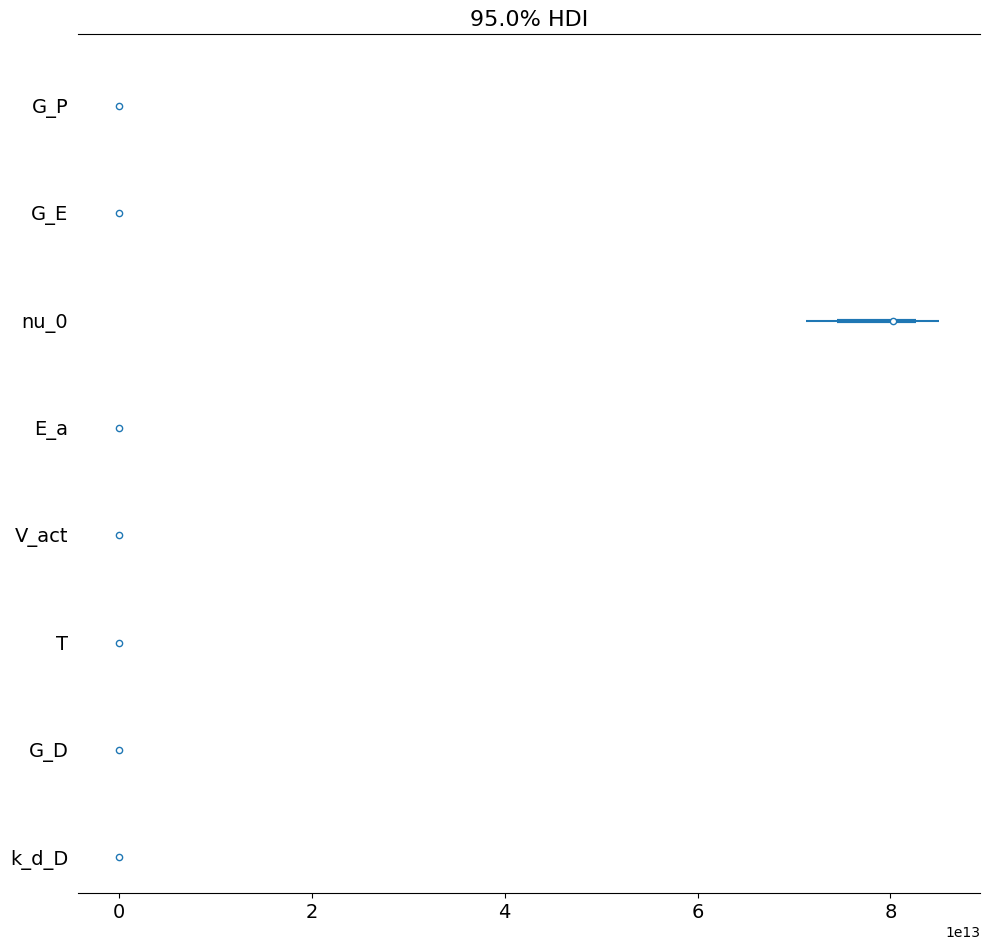

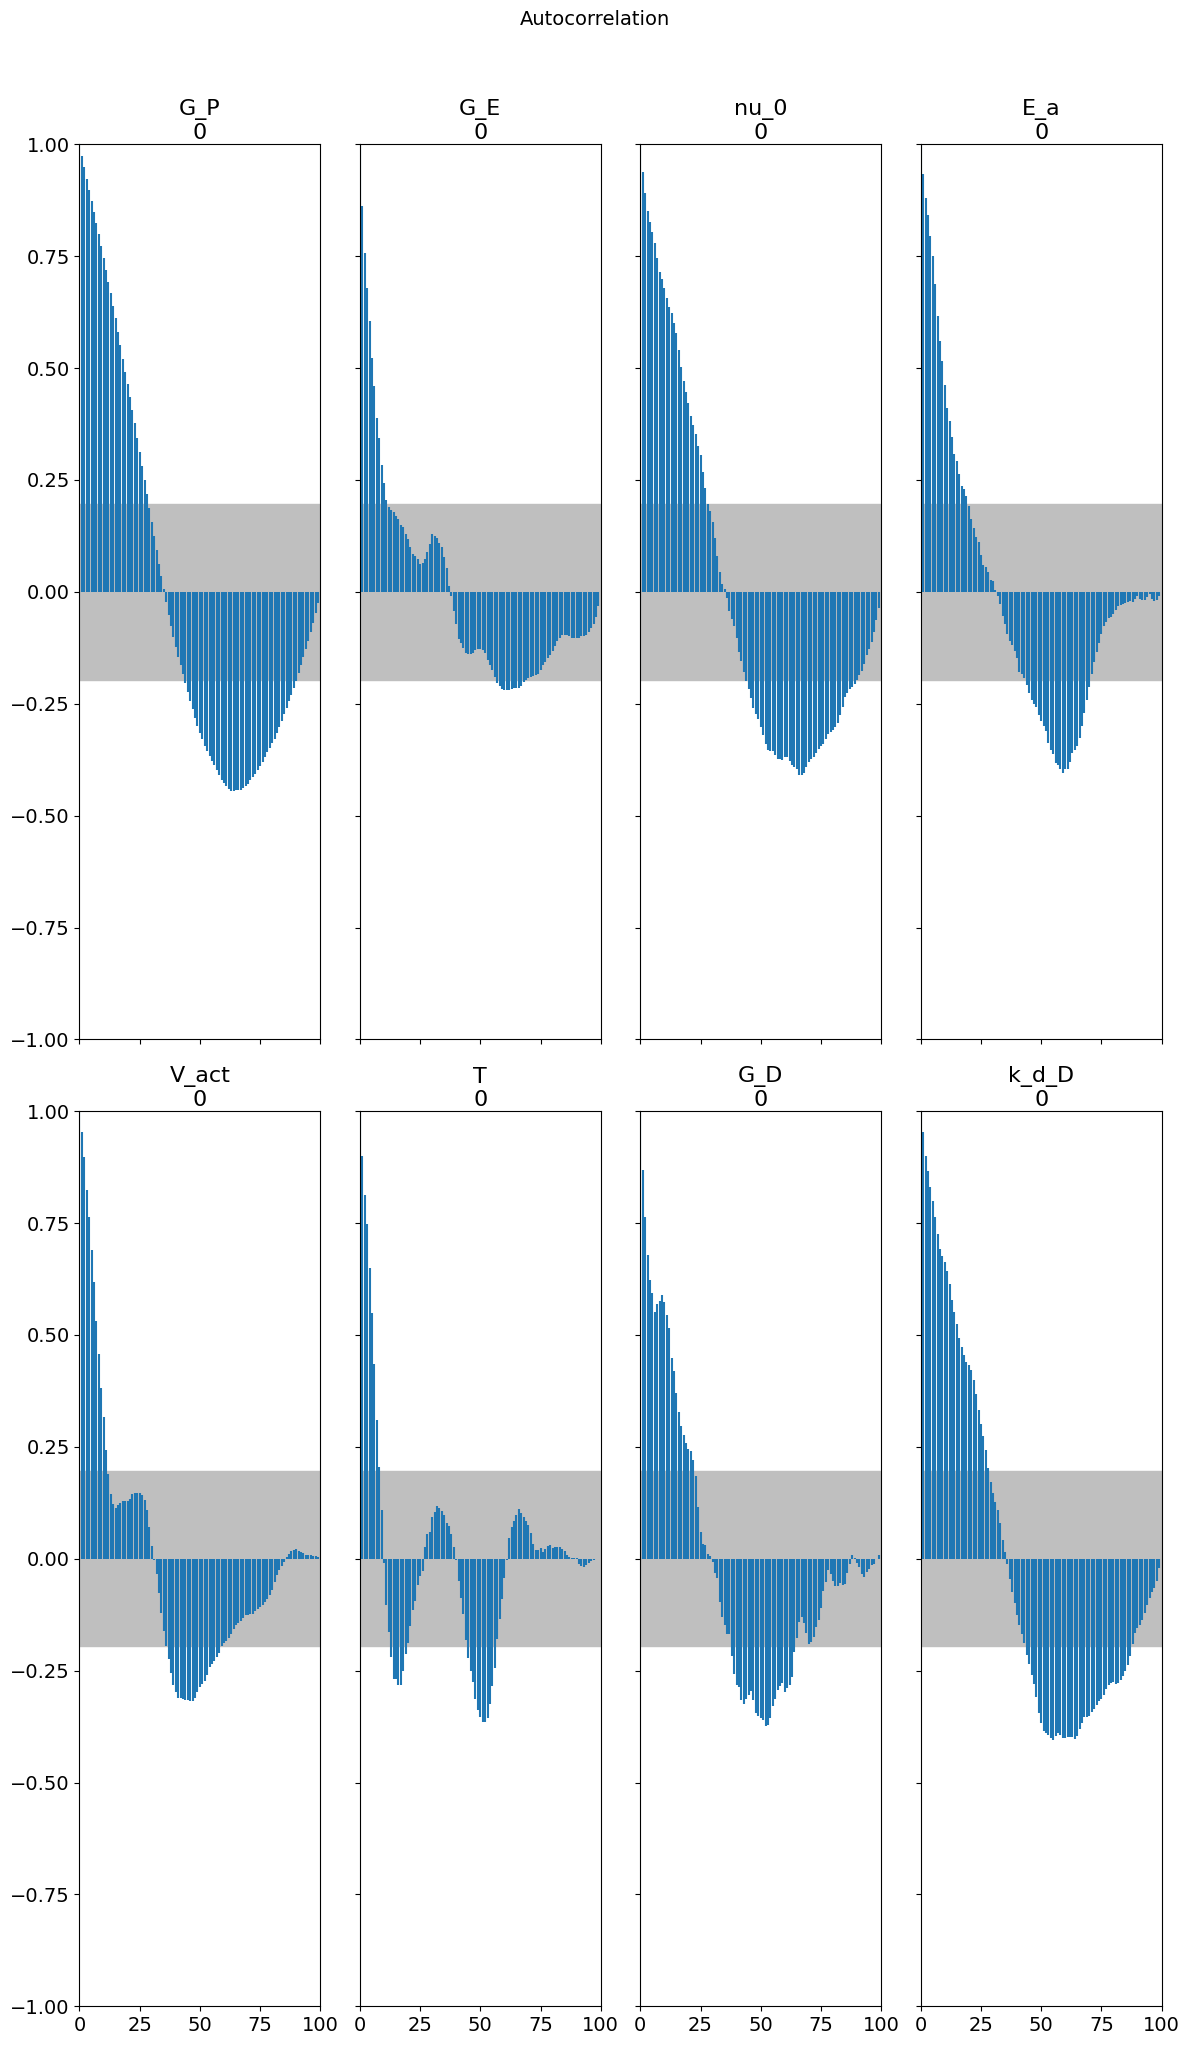

In [8]:
# Trace and forest plots
display_arviz_diagnostics(nuts_result, param_names, fast_mode=FAST_MODE)

## 9. Full Trajectory: Stress Components and Natural State

Decompose total stress into network contributions and visualize natural-state lag.

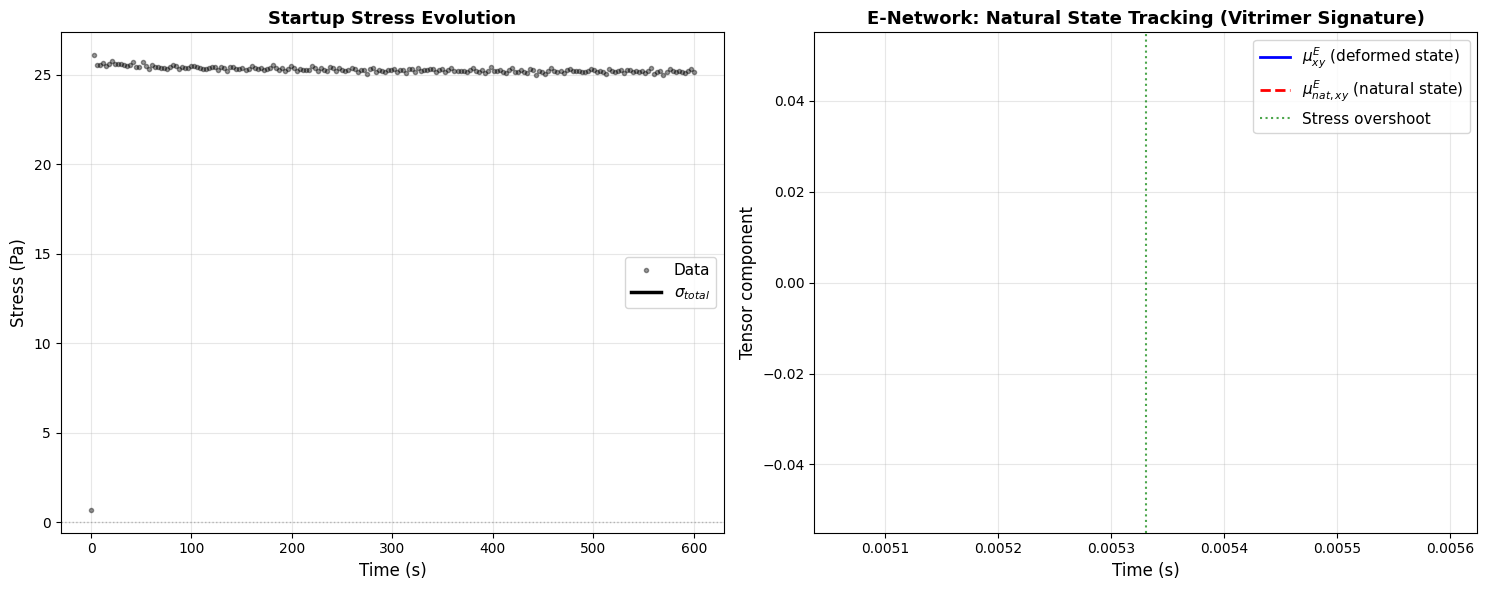


Key observations:
- μ^E_xy grows with deformation (affine)
- μ^E_nat_xy lags behind → transient stress (overshoot)
- At long times: μ^E → μ^E_nat ⇒ σ_E → 0 (stress relaxation via BER)
- P-network contributes linearly growing stress: σ_P = G_P·γ̇·t


In [9]:
# Simulate with full trajectory
full_result = model.simulate_startup(
    t_fit,
    gamma_dot=gamma_dot,
    return_full=True,
)

# Two-panel plot: stress components and natural state tracking
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Panel 1: Stress components
ax1.plot(time, stress, 'ko', markersize=3, alpha=0.4, label='Data')
ax1.plot(full_result['time'], full_result['stress'], 'k-', lw=2.5, label='$\\sigma_{total}$')

# Note: Component stresses would require additional model output
# For now, show total and annotate behavior
ax1.axhline(0, color='gray', ls=':', lw=1, alpha=0.5)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Stress (Pa)', fontsize=12)
ax1.set_title('Startup Stress Evolution', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Panel 2: E-Network natural state tracking
ax2.plot(full_result['time'], full_result['mu_E_xy'], 'b-', lw=2,
         label='$\\mu^E_{xy}$ (deformed state)')
ax2.plot(full_result['time'], full_result['mu_E_nat_xy'], 'r--', lw=2,
         label='$\\mu^E_{nat,xy}$ (natural state)')

# Annotate lag region
ax2.axvline(time_peak_fit, color='green', ls=':', lw=1.5, alpha=0.7,
            label='Stress overshoot')

ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Tensor component', fontsize=12)
ax2.set_title('E-Network: Natural State Tracking (Vitrimer Signature)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nKey observations:")
print("- μ^E_xy grows with deformation (affine)")
print("- μ^E_nat_xy lags behind → transient stress (overshoot)")
print("- At long times: μ^E → μ^E_nat ⇒ σ_E → 0 (stress relaxation via BER)")
print("- P-network contributes linearly growing stress: σ_P = G_P·γ̇·t")

## 10. Shear Rate Comparison

Fit startup data at multiple shear rates to examine overshoot dependence.

**Expected:** Overshoot magnitude and peak strain may vary with $\dot{\gamma}$.

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.247348s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=6 | final_cost=154.6926 | elapsed=0.247s | final_gradient_norm=454.5914


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.236858s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=9 | final_cost=130.2662 | elapsed=0.237s | final_gradient_norm=386.9879


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.246117s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=11 | final_cost=240.8286 | elapsed=0.246s | final_gradient_norm=685.2818


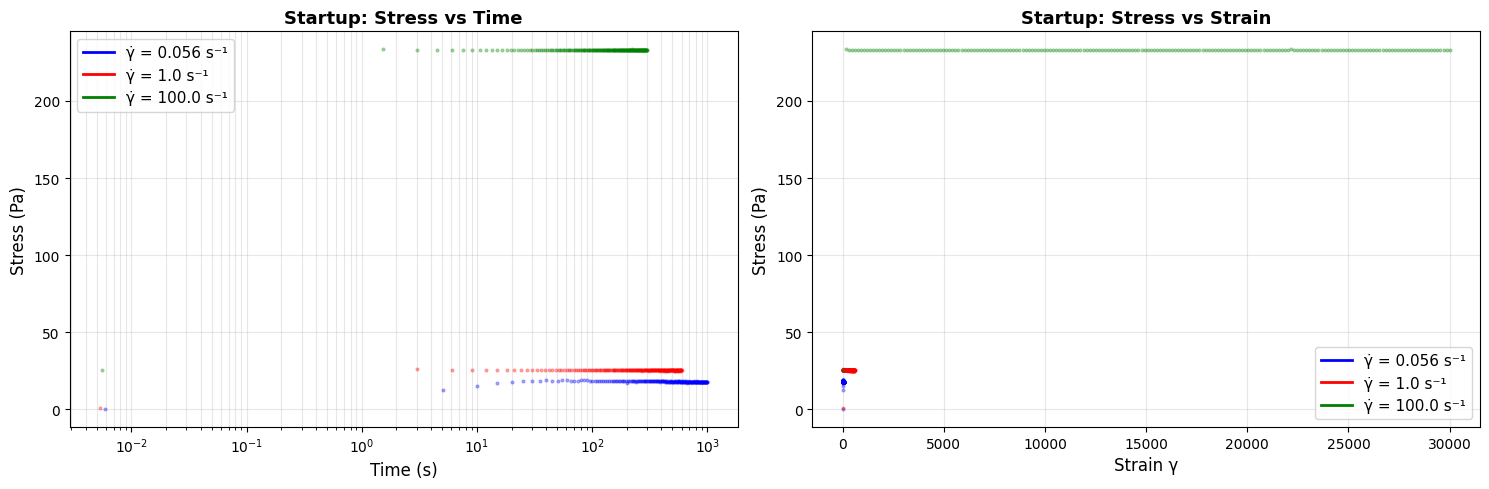


Overshoot characteristics:
γ̇ (s⁻¹)     σ_peak (Pa)     γ_peak    
----------------------------------------
5.60e-02     nan             0.00      
1.00e+00     nan             0.01      
1.00e+02     nan             0.56      


In [10]:
# Load data at multiple shear rates
gamma_dots = [0.056, 1.0, 100.0]
colors = ['blue', 'red', 'green']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

overshoot_data = []

for i, gd in enumerate(gamma_dots):
    # Load data
    t_data, s_data = load_pnas_startup(gamma_dot=gd, max_points=200)
    
    # Fit (NLSQ only for speed)
    model_temp = HVMLocal(include_dissociative=True)
    model_temp.parameters.set_value("T", 300.0)
    model_temp.parameters.set_value("G_P", 30.0)
    model_temp.parameters.set_value("G_E", 20.0)
    model_temp.parameters.set_value("G_D", 15.0)
    model_temp.parameters.set_value("k_d_D", 1.0)
    
    try:
        run_nlsq_protocol(
            model_temp,
            t_data,
            s_data,
            test_mode='startup',
            gamma_dot=gd,
        )
        
        # Generate fit
        t_pred = np.linspace(t_data.min(), t_data.max(), 200)
        s_pred = model_temp.simulate_startup(t_pred, gamma_dot=gd)
        
        # Find overshoot
        peak_idx = np.argmax(s_pred)
        t_peak = t_pred[peak_idx]
        s_peak = s_pred[peak_idx]
        gamma_peak = gd * t_peak
        
        overshoot_data.append({
            'gamma_dot': gd,
            'stress_peak': s_peak,
            'strain_peak': gamma_peak,
        })
        
        # Plot vs time
        ax1.plot(t_data, s_data, 'o', color=colors[i], markersize=2, alpha=0.3)
        ax1.plot(t_pred, s_pred, '-', color=colors[i], lw=2,
                label=f'γ̇ = {gd} s⁻¹')
        
        # Plot vs strain
        gamma_data = gd * t_data
        gamma_pred = gd * t_pred
        ax2.plot(gamma_data, s_data, 'o', color=colors[i], markersize=2, alpha=0.3)
        ax2.plot(gamma_pred, s_pred, '-', color=colors[i], lw=2,
                label=f'γ̇ = {gd} s⁻¹')
    
    except Exception as e:
        print(f"Warning: Fit failed for γ̇={gd}: {e}")

# Format plots
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Stress (Pa)', fontsize=12)
ax1.set_title('Startup: Stress vs Time', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, which='both')

ax2.set_xlabel('Strain γ', fontsize=12)
ax2.set_ylabel('Stress (Pa)', fontsize=12)
ax2.set_title('Startup: Stress vs Strain', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

# Overshoot summary
print("\nOvershoot characteristics:")
print(f"{'γ̇ (s⁻¹)':<12} {'σ_peak (Pa)':<15} {'γ_peak':<10}")
print("-" * 40)
for data in overshoot_data:
    print(f"{data['gamma_dot']:<12.2e} {data['stress_peak']:<15.2f} {data['strain_peak']:<10.2f}")

## 11. Save Results

In [11]:
# Get output directory
output_dir = get_output_dir("startup")

# Save results
save_results(
    output_dir,
    model=model,
    result=nuts_result,
    param_names=param_names,
    extra_meta={
        'protocol': 'startup',
        'material': 'pnas_digital_rheometer',
        'fast_mode': FAST_MODE,
    },
)

print(f"\nResults saved to: {output_dir}")

Results saved to /Users/b80985/Projects/rheojax/examples/outputs/hvm/startup/

Results saved to: /Users/b80985/Projects/rheojax/examples/outputs/hvm/startup


## Summary

**Key findings:**
1. HVM captures stress overshoot in startup shear flow
2. Physical origin in HVM:
   - E-network: $\mu^E_{nat}$ lags $\mu^E$ → transient stress before BER catches up
   - D-network: conventional Maxwell overshoot
   - P-network: linearly growing stress $\sigma_P = G_P \dot{\gamma} t$
3. Natural state tracking visible in tensor evolution
4. Overshoot characteristics vary with shear rate
5. $V_{act}$ controls overshoot magnitude (primary parameter from startup)

**Important note:**
- Data is from a thixotropic fluid, not a true vitrimer
- Real vitrimer startup would show similar overshoot but from BER kinetics
- This demonstrates HVM's capability to model transient shear flows

## Further Reading

**Handbook Documentation:**
- [HVM Model Reference](../../docs/source/models/hvm/hvm.rst) — TST kinetics (stress and stretch coupling modes), factor-of-2
- [HVM Knowledge Extraction](../../docs/source/models/hvm/hvm_knowledge.rst) — $V_{act}$ determination from startup data (step 4 of fitting strategy)
- [HVM Protocol Derivations](../../docs/source/models/hvm/hvm_protocols.rst) — Startup ODE, constant-rate analytical solution

**References:**
1. Vernerey, F.J., Long, R. & Brighenti, R. (2017). A statistically-based continuum theory for polymers with transient networks. *J. Mech. Phys. Solids*, 107, 1-20.
2. Meng, F., Pritchard, R.H. & Terentjev, E.M. (2016). Stress relaxation, dynamics, and plasticity of transient polymer networks. *Macromolecules*, 49, 2843-2852.

## Next Notebooks

- **Notebook 12**: SAOS NLSQ + NUTS (frequency-domain with temperature series)
- **Notebook 13**: LAOS Harmonic Analysis (nonlinear oscillatory response)